# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

# Table of Contents

<div class = "alert alert-block alert-info" style = "margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Imports</a>

2.  <a href="#item2">Loading the data</a>

3.  <a href="#item3">Scraping the data</a>

4.  <a href="#item4">Data Wrangling</a>

5.  <a href="#item5">Loading Foursquare Credentials</a>  
    
6.  <a href="#item5">Getting Latitude and Longitude</a> 
    
7.  <a href="#item5">Pre Processing</a> 
    
8.  <a href="#item5">Clustering Neighborhoods</a> 
    
9.  <a href="#item5">Analyzing the clusters</a> 

</font>
</div>

# 1. Imports

In [1]:
!conda install --yes beautifulsoup4

!pip install lxml

!conda install -c conda-forge folium=0.5.0 --yes

!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.3       |     pyhb0f4dca_0          91 KB
    ca-certificates-2020.10.14 |                0         121 KB
    certifi-2020.6.20          |     pyhd3eb1b0_3         155 KB
    openssl-1.1.1h             |       h7b6447c_0         2.5 MB
    soupsieve-2.0.1            |             py_0          33 KB
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     pkgs/main/noarch::beautifulsoup4-4.9.3-pyhb0f4dca_0
  soupsieve          pkgs/main/noarch::soupsieve-2.0.1-py_0

The following packages will be UPDATED:

  ca-certificates    co

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import silhouette_samples, silhouette_score

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. Loading data

## 2.1 Loading Canada´s Postal code, Borough and Neighbourhood information

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(source, 'xml')
table = soup.find('table')

In [4]:
columns_names = ['Postalcode','Borough','Neighbourhood']
df = pd.DataFrame(columns = columns_names)


## 2.2 Loading the Geospatial Coordinates

In [5]:
dfgc = pd.read_csv('Geospatial_Coordinates.csv')
dfgc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# 3 Scraping the data

In [6]:
for tr in table.find_all('tr'):
    row_data=[]
    for td in tr.find_all('td'):
        row_data.append(td.text.strip())         
    if len(row_data)==3:
        df.loc[len(df)] = row_data


# 4 Data Wrangling

In [7]:
for i in range(len(df)):
    if df['Neighbourhood'].loc[i] == 'Not assigned':
        a = df['Neighbourhood'].loc[i]
        b = df['Borough'].loc[i]
        df['Neighbourhood'].replace(a, b)

In [8]:
for i in range(len(df)):
    if df['Borough'].loc[i] == 'Not assigned':
        df = df.drop(i)

In [9]:
df = df.reset_index(drop = True) # prevent it to create a "column" named index

In [10]:
df.head()

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [11]:
df.shape

(103, 3)

In [12]:
dfgc.rename(columns={'Postal Code' : 'Postalcode'}, inplace = True)

In [13]:
fulldf = pd.merge(df, dfgc, left_on = 'Postalcode', right_on = 'Postalcode')
fulldf.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [14]:
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

## 4.4 Creating a new Dataframe

In [15]:
toronto_data = fulldf.copy()
toronto_data.reset_index(drop = True)
toronto_data.drop(['Postalcode'], axis =1, inplace = True)
toronto_data.drop(['Borough'], axis = 1, inplace = True)
toronto_data.head()

,Neighbourhood,Latitude,Longitude
0,Parkwoods,43.753259,-79.329656
1,Victoria Village,43.725882,-79.315572
2,"Regent Park, Harbourfront",43.654260,-79.360636
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [16]:
# toronto_data = toronto_data.sort_values(['Neighbourhood'], ascending = True)
# toronto_data = toronto_data.reset_index(drop = True)
# toronto_datall = toronto_data[['Latitude', 'Longitude']]

In [17]:
toronto_data.head()

,Neighbourhood,Latitude,Longitude
0,Parkwoods,43.753259,-79.329656
1,Victoria Village,43.725882,-79.315572
2,"Regent Park, Harbourfront",43.654260,-79.360636
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# 5 Loading Foursquare Credentials

In [18]:
CLIENT_ID ='' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

# 6 Getting Latitude and Longitude

In [19]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


# 7 Pre Processing

In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             lat, 
#             lng, 
#             radius, 
#             LIMIT)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Neighbourhood', 
#                   'Neighbourhood Latitude', 
#                   'Neighbourhood Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
    
#     return(nearby_venues)

In [23]:
# toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
#                                    latitudes=toronto_data['Latitude'],
#                                    longitudes=toronto_data['Longitude']
#                                   )

In [24]:
explore_df_list = []

for i, nhood_name in enumerate(toronto_data['Neighbourhood']):  
    
    try :
        #Get neighbourhood data
        nhood_name = toronto_data.loc[i, 'Neighbourhood']
        nhood_lat = toronto_data.loc[i, 'Latitude']
        nhood_lng = toronto_data.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nhood_lat, nhood_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flatten JSON

        # Filter the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Rename the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Get the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Get the required data
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nhood_name, nhood_lat, nhood_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [47]:
explore_toronto = pd.DataFrame([item for item in explore_df_list])
explore_toronto.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_toronto.head(20)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park,43.751976,-79.332140
2,Parkwoods,43.753259,-79.329656,Tim Hortons,Café,43.760668,-79.326368
3,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,Grocery Store,43.746143,-79.324630
4,Parkwoods,43.753259,-79.329656,A&W,Fast Food Restaurant,43.760643,-79.326865
5,Parkwoods,43.753259,-79.329656,Shoppers Drug Mart,Pharmacy,43.760857,-79.324961
6,Parkwoods,43.753259,-79.329656,Food Basics,Supermarket,43.760549,-79.326045
7,Parkwoods,43.753259,-79.329656,Shoppers Drug Mart,Pharmacy,43.745315,-79.325800
8,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,Fish & Chips Shop,43.745260,-79.324949
9,Parkwoods,43.753259,-79.329656,Pizza Pizza,Pizza Place,43.760231,-79.325666


## Analyze Neighborhood

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(explore_toronto[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = explore_toronto['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Re

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Re

In [28]:
# Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Bakery,Caribbean Restaurant,Shopping Mall,Seafood Restaurant,Sushi Restaurant,Supermarket,Sri Lankan Restaurant,Latin American Restaurant,Lounge
1,"Alderwood, Long Branch",Discount Store,Pizza Place,Convenience Store,Pharmacy,Pub,Coffee Shop,Liquor Store,Intersection,Shopping Mall,Garden Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Dog Run,Fried Chicken Joint,Mediterranean Restaurant,Sushi Restaurant,Supermarket,Diner,Restaurant,Sandwich Place
3,Bayview Village,Gas Station,Grocery Store,Japanese Restaurant,Bank,Chinese Restaurant,Restaurant,Café,Trail,Park,Skating Rink
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Sports Club,Baby Store,Bagel Shop,Bakery,Sushi Restaurant,Pub,Liquor Store


# 8 Clustering

In [30]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# toronto_grouped_clustering = toronto_grouped_clustering.reset_index(drop = True)

In [31]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

## 8.1 Finding the Best K

In [32]:
max_range = 15 #Max range 15 (number of clusters)

indices = []
scores = []

for toronto_clusters in range(2, max_range) :
    
    # Run k-means clustering
    toronto_gc = toronto_grouped_clustering
    kmeans = KMeans(n_clusters = toronto_clusters, init = 'k-means++', random_state = 0).fit_predict(toronto_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(toronto_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(toronto_clusters)
    scores.append(score)

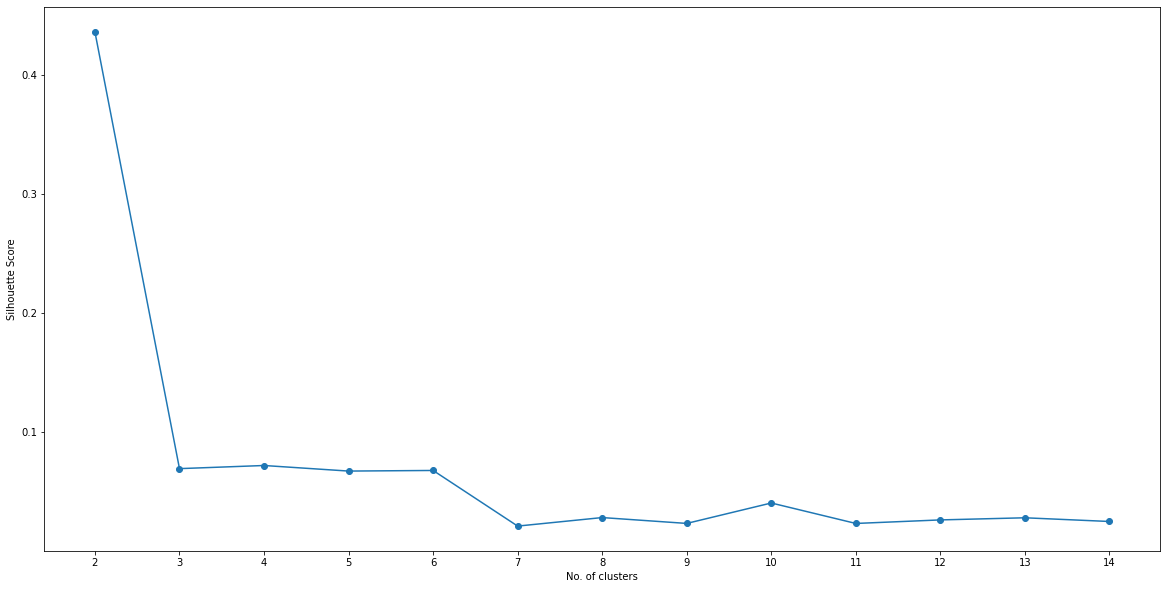

In [33]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [34]:
opt_value = 8

## 8.2 Using the Best K

In [35]:
toronto_clusters = opt_value

# Run k-means clustering
# toronto_gc = toronto_grouped_clustering
kmeans = KMeans(n_clusters = toronto_clusters, init = 'k-means++', random_state = 0)
kmeans.fit(toronto_gc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [36]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# toronto_datall.insert(0, 'Neighbourhood', toronto_data['Neighbourhood'])

In [37]:
toronto_final = toronto_data
toronto_final = toronto_final.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_final.dropna(inplace = True)
toronto_final['Cluster Labels'] = toronto_final['Cluster Labels'].astype(int)
toronto_final.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.753259,-79.329656,1,Park,Pharmacy,Convenience Store,Shopping Mall,Bus Stop,Fast Food Restaurant,Tennis Court,Shop & Service,Fish & Chips Shop,Food & Drink Shop
1,Victoria Village,43.725882,-79.315572,6,Coffee Shop,Boxing Gym,Golf Course,Portuguese Restaurant,Men's Store,Pizza Place,Sporting Goods Shop,Intersection,Playground,Gym / Fitness Center
2,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Performing Arts Venue,Theater,Mediterranean Restaurant,Breakfast Spot,Spa,Liquor Store,Café
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,6,Coffee Shop,Fast Food Restaurant,Clothing Store,Vietnamese Restaurant,Fried Chicken Joint,Sushi Restaurant,Restaurant,Dessert Shop,Event Space,Pet Store
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Park,Yoga Studio,Gastropub,Ramen Restaurant,Portuguese Restaurant,Museum,Middle Eastern Restaurant,Mexican Restaurant,Italian Restaurant


In [38]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Setup color scheme for different clusters
x = np.arange(toronto_clusters)
ys = [i + x + (i*x)**2 for i in range(toronto_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_final['Latitude'], toronto_final['Longitude'], toronto_final['Neighbourhood'], 
                                  toronto_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

# 9 Analyzing the clusters

DataFrame.insert(loc, column, value, allow_duplicates=False)

In [39]:
val = 1
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Performing Arts Venue,Theater,Mediterranean Restaurant,Breakfast Spot,Spa,Liquor Store,Café
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Park,Yoga Studio,Gastropub,Ramen Restaurant,Portuguese Restaurant,Museum,Middle Eastern Restaurant,Mexican Restaurant,Italian Restaurant
7,Don Mills,Restaurant,Japanese Restaurant,Gym,Bank,Burger Joint,Coffee Shop,Supermarket,Beer Store,Pizza Place,Asian Restaurant
13,Don Mills,Restaurant,Japanese Restaurant,Gym,Bank,Burger Joint,Coffee Shop,Supermarket,Beer Store,Pizza Place,Asian Restaurant
19,The Beaches,Park,Beach,Japanese Restaurant,Breakfast Spot,Pub,Bagel Shop,Gastropub,Bar,Bakery,Mediterranean Restaurant
23,Leaside,Sporting Goods Shop,Coffee Shop,Burger Joint,Sandwich Place,Auto Dealership,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Shopping Mall
24,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Yoga Studio,Gastropub,Park,Middle Eastern Restaurant,Miscellaneous Shop,Seafood Restaurant,Modern European Restaurant
33,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Juice Bar,Restaurant,Bakery,Cosmetics Shop,Shopping Mall,Electronics Store,Liquor Store,Movie Theater
37,"Little Portugal, Trinity",Bar,Asian Restaurant,Men's Store,Yoga Studio,Japanese Restaurant,Cocktail Bar,Ice Cream Shop,Italian Restaurant,French Restaurant,New American Restaurant
41,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Ice Cream Shop,Yoga Studio,Cocktail Bar,Brewery,Concert Hall,Spa,Bookstore,Restaurant


In [40]:
val = 2
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Pharmacy,Convenience Store,Shopping Mall,Bus Stop,Fast Food Restaurant,Tennis Court,Shop & Service,Fish & Chips Shop,Food & Drink Shop
5,"Islington Avenue, Humber Valley Village",Pharmacy,Playground,Park,Bakery,Café,Shopping Mall,Golf Course,Skating Rink,Bank,Grocery Store
6,"Malvern, Rouge",Fast Food Restaurant,Trail,Coffee Shop,Spa,Caribbean Restaurant,Supermarket,Bank,Bakery,Chinese Restaurant,Restaurant
8,"Parkview Hill, Woodbine Gardens",Construction & Landscaping,Pizza Place,Gym / Fitness Center,Brewery,Soccer Stadium,Intersection,Coffee Shop,Rock Climbing Spot,Bus Line,Fast Food Restaurant
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Coffee Shop,Farmers Market,Liquor Store,Intersection,Shopping Plaza,Gas Station,Beer Store,Fish & Chips Shop,College Rec Center,Grocery Store
21,Caledonia-Fairbanks,Pizza Place,Pharmacy,Park,Coffee Shop,Fast Food Restaurant,Falafel Restaurant,Bus Line,Bus Stop,Food Truck,Discount Store
22,Woburn,Park,Coffee Shop,Fast Food Restaurant,Mobile Phone Shop,Chinese Restaurant,Indian Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Dry Cleaner
26,Cedarbrae,Coffee Shop,Bakery,Indian Restaurant,Pharmacy,Gas Station,Bank,Fast Food Restaurant,Caribbean Restaurant,Fried Chicken Joint,Chinese Restaurant
27,Hillcrest Village,Pharmacy,Park,Coffee Shop,Bakery,Bank,Recreation Center,Residential Building (Apartment / Condo),Ice Cream Shop,Korean Restaurant,Shopping Mall
28,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Dog Run,Fried Chicken Joint,Mediterranean Restaurant,Sushi Restaurant,Supermarket,Diner,Restaurant,Sandwich Place


In [41]:
val = 3
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",Playground,Park,Burger Joint,Italian Restaurant,Breakfast Spot,Cuban Restaurant,Doner Restaurant,Field,Fast Food Restaurant,Farmers Market


In [42]:
val = 4
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",Park,Pizza Place,Hotel,Clothing Store,Restaurant,Mexican Restaurant,Bank,Grocery Store,Fish & Chips Shop,Gym
51,"Cliffside, Cliffcrest, Scarborough Village West",Pizza Place,Beach,Ice Cream Shop,Hardware Store,Sports Bar,Park,Restaurant,Dumpling Restaurant,Dog Run,Doner Restaurant
58,"Birch Cliff, Cliffside West",Park,Restaurant,Thai Restaurant,Convenience Store,Diner,Gym Pool,College Stadium,Gym,Skating Rink,Ice Cream Shop
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Park,Ice Cream Shop,Italian Restaurant,Gym / Fitness Center,Shopping Mall,Eastern European Restaurant,Bus Stop,Doner Restaurant,Donut Shop,Dry Cleaner


In [43]:
val = 5
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",Park,Pool,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant


In [44]:
val = 6
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Garden District, Ryerson",Theater,Bookstore,New American Restaurant,Diner,Sandwich Place,Supermarket,Café,Japanese Restaurant,Music Venue,Burrito Place
14,Woodbine Heights,Park,Coffee Shop,Skating Rink,Pizza Place,Café,Sandwich Place,Plaza,Dance Studio,Liquor Store,Beer Store
15,St. James Town,Gastropub,Coffee Shop,Café,Restaurant,Japanese Restaurant,Farmers Market,Food Truck,Diner,Italian Restaurant,BBQ Joint
20,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Fish Market,Bistro,Japanese Restaurant,Basketball Stadium,French Restaurant,Fountain
25,Christie,Café,Coffee Shop,Grocery Store,Korean Restaurant,Cocktail Bar,Playground,Indian Restaurant,South American Restaurant,Spa,Sandwich Place
30,"Richmond, Adelaide, King",Café,Concert Hall,Coffee Shop,American Restaurant,Restaurant,Mediterranean Restaurant,Steakhouse,Jazz Club,Speakeasy,Bookstore
31,"Dufferin, Dovercourt Village",Café,Coffee Shop,Portuguese Restaurant,Bar,Bakery,Italian Restaurant,Brewery,Grocery Store,Mexican Restaurant,Middle Eastern Restaurant
35,"East Toronto, Broadview North (Old East York)",Café,Bakery,American Restaurant,Gastropub,Coffee Shop,Thai Restaurant,Farmers Market,Middle Eastern Restaurant,Breakfast Spot,Ethiopian Restaurant
36,"Harbourfront East, Union Station, Toronto Islands",Park,Hotel,Plaza,Café,Monument / Landmark,Sporting Goods Shop,Japanese Restaurant,Supermarket,Basketball Stadium,Roof Deck
42,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Restaurant,Café,Hotel,Japanese Restaurant,Asian Restaurant,Beer Bar,Basketball Stadium,Museum,Speakeasy


In [45]:
val = 7
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Coffee Shop,Boxing Gym,Golf Course,Portuguese Restaurant,Men's Store,Pizza Place,Sporting Goods Shop,Intersection,Playground,Gym / Fitness Center
3,"Lawrence Manor, Lawrence Heights",Coffee Shop,Fast Food Restaurant,Clothing Store,Vietnamese Restaurant,Fried Chicken Joint,Sushi Restaurant,Restaurant,Dessert Shop,Event Space,Pet Store
10,Glencairn,Grocery Store,Fast Food Restaurant,Pizza Place,Gas Station,Coffee Shop,Metro Station,Bakery,Bank,Latin American Restaurant,Pet Store
16,Humewood-Cedarvale,Pizza Place,Convenience Store,Coffee Shop,Intersection,Dance Studio,Optical Shop,Restaurant,Sandwich Place,Bus Line,Middle Eastern Restaurant
18,"Guildwood, Morningside, West Hill",Pizza Place,Bank,Fast Food Restaurant,Coffee Shop,Restaurant,Smoothie Shop,Bus Line,Liquor Store,Sports Bar,Food & Drink Shop
32,Scarborough Village,Ice Cream Shop,Grocery Store,Fast Food Restaurant,Japanese Restaurant,Restaurant,Train Station,Coffee Shop,Sandwich Place,Bowling Alley,Pizza Place
34,"Northwood Park, York University",Furniture / Home Store,Coffee Shop,Restaurant,Pizza Place,Fast Food Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Sports Bar,Caribbean Restaurant,Sandwich Place
39,Bayview Village,Gas Station,Grocery Store,Japanese Restaurant,Bank,Chinese Restaurant,Restaurant,Café,Trail,Park,Skating Rink
56,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Furniture / Home Store,Grocery Store,Gas Station,Discount Store,Dessert Shop,Italian Restaurant,Restaurant,Sandwich Place,Video Store,Convenience Store
59,"Willowdale, Willowdale East",Pizza Place,Korean Restaurant,Grocery Store,Sushi Restaurant,Café,Juice Bar,Bakery,Japanese Restaurant,Supermarket,Steakhouse


In [46]:
val = 8
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,"Northwest, West Humber - Clairville",Lounge,Coffee Shop,Event Space,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio
